<a href="https://colab.research.google.com/github/viniciusbedeschi/TCC/blob/main/TCC_Random_Forest_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

#Conectando o notebook com o Drive
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import auth
import gspread

#Importando as bibliotecas do Sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

Mounted at /content/gdrive


#Impotando a Base de Dados

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/Base de dados/Base_Tratada_Selecionada_lof.csv')
display(df)

,tempo_entrega_days_real,order_item_id,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,Distance,January,...,October,November,December,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,4.179016,1.0,116.9,18.92,400.0,19.0,13.0,19.0,400.466657,0,...,0,0,0,0,0,0,1,0,0,0
1,1.134433,1.0,118.7,9.34,400.0,19.0,13.0,19.0,15.654501,0,...,0,0,0,0,0,1,0,0,0,0
2,0.993021,1.0,116.9,9.33,400.0,19.0,13.0,19.0,19.466840,0,...,0,0,0,0,1,0,0,0,0,0
3,3.067801,1.0,118.7,15.93,400.0,19.0,13.0,19.0,523.062446,0,...,0,0,0,0,0,0,0,1,0,0
4,2.208646,1.0,116.9,18.92,400.0,19.0,13.0,19.0,400.466657,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6101,3.155903,1.0,99.0,22.51,5750.0,30.0,30.0,30.0,183.018773,0,...,0,0,0,0,0,0,0,0,0,1
6102,4.297674,1.0,57.2,12.84,150.0,22.0,3.0,15.0,134.240374,0,...,0,0,0,0,0,0,0,1,0,0
6103,7.328889,1.0,159.9,13.78,245.0,26.0,8.0,17.0,339.125166,0,...,0,0,0,1,0,0,0,0,0,0
6104,11.355266,1.0,129.9,13.35,150.0,16.0,11.0,11.0,123.276953,0,...,0,0,0,0,0,0,1,0,0,0


#Implementando a Randon Forest

Dividindo Daddos de treino e coluna alvo

In [4]:
df_treino = df[['price', 'freight_value', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'Distance', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
df_alvo = df[['tempo_entrega_days_real']]

In [5]:
scaler = MinMaxScaler()
df_treino_norm = pd.DataFrame(scaler.fit_transform(df_treino), columns=df_treino.columns)
display(df_treino_norm)

,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,Distance,January,February,March,...,October,November,December,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0.068339,0.132781,0.028470,0.085106,0.106796,0.141176,0.391954,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.069399,0.065548,0.028470,0.085106,0.106796,0.141176,0.015322,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.068339,0.065478,0.028470,0.085106,0.106796,0.141176,0.019053,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.069399,0.111797,0.028470,0.085106,0.106796,0.141176,0.511944,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.068339,0.132781,0.028470,0.085106,0.106796,0.141176,0.391954,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6101,0.057798,0.157976,0.409253,0.202128,0.271845,0.270588,0.179128,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6102,0.033183,0.090112,0.010676,0.117021,0.009709,0.094118,0.131387,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6103,0.093661,0.096709,0.017438,0.159574,0.058252,0.117647,0.331916,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6104,0.075994,0.093691,0.010676,0.053191,0.087379,0.047059,0.120656,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [6]:
kfold = KFold(n_splits=10, shuffle=False)

In [7]:
scores_mse = []
scores_mae = []
scores_r2 = []
scores_mape = []
fold = 0

y_tests = []
y_preds = []

for train, test in kfold.split(df_treino):
  model = RandomForestRegressor(random_state=42, n_estimators=500,  max_depth=50, min_samples_leaf=1, max_features = 'sqrt', min_samples_split = 50)
  X_train, X_test = df_treino.iloc[train], df_treino.iloc[test]
  y_train, y_test = df_alvo.iloc[train], df_alvo.iloc[test]

  model.fit(X_train, y_train.values.ravel())

  pred = model.predict(X_test)

  y_tests.append(y_test)
  y_preds.append(pred)

  mse = mean_squared_error(y_test, pred)
  scores_mse.append(mse)
  mae = mean_absolute_error(y_test, pred)
  scores_mae.append(mae)
  r2 = r2_score(y_test, pred)
  scores_r2.append(r2)
  MAPE = mean_absolute_percentage_error(y_test, pred)
  scores_mape.append(MAPE)

  print('\nFold '+ str(fold))
  print('MSE: {}, MAE: {}, MAPE:{}, R²: {}'.format(mse, mae, MAPE, r2))

  fold += 1
print('\nFloresta Aleatória:')
print('\nAcurácia média (MSE):', np.mean(scores_mse))
print('\nAcurácia média (MAE):', np.mean(scores_mae))
print('\nAcurácia média (MAPE):', np.mean(scores_mape))
#print('\nR² médio:', np.mean(scores_r2))


Fold 0
MSE: 21.037818297128176, MAE: 2.9268723855624947, MAPE:0.679250473856947, R²: 0.585373092920223

Fold 1
MSE: 29.509958334211582, MAE: 2.7258018222005442, MAPE:0.6009859095435319, R²: 0.3597401465575937

Fold 2
MSE: 18.883669982958295, MAE: 2.914853389422404, MAPE:0.785472261317271, R²: 0.2346120029923896

Fold 3
MSE: 11.842391829313788, MAE: 2.3557556278757317, MAPE:0.7242605297399022, R²: 0.4891630542173514

Fold 4
MSE: 19.355345651849117, MAE: 2.5980838063697913, MAPE:0.7494590876393, R²: 0.2571044178785631

Fold 5
MSE: 18.586301847816753, MAE: 2.561252671610056, MAPE:0.6927769059690871, R²: 0.3244359370999259

Fold 6
MSE: 24.416261611343536, MAE: 2.6767558272514846, MAPE:0.6999183620207176, R²: 0.2786492069509927

Fold 7
MSE: 20.691639197006086, MAE: 2.605580680850537, MAPE:0.736281079641322, R²: 0.3123360962458791

Fold 8
MSE: 12.296049550696024, MAE: 2.3028746577323376, MAPE:0.6517061627691497, R²: 0.3365074232572344

Fold 9
MSE: 11.192152563403397, MAE: 2.156401250241042,

Gráfico de Importância das Variavéis

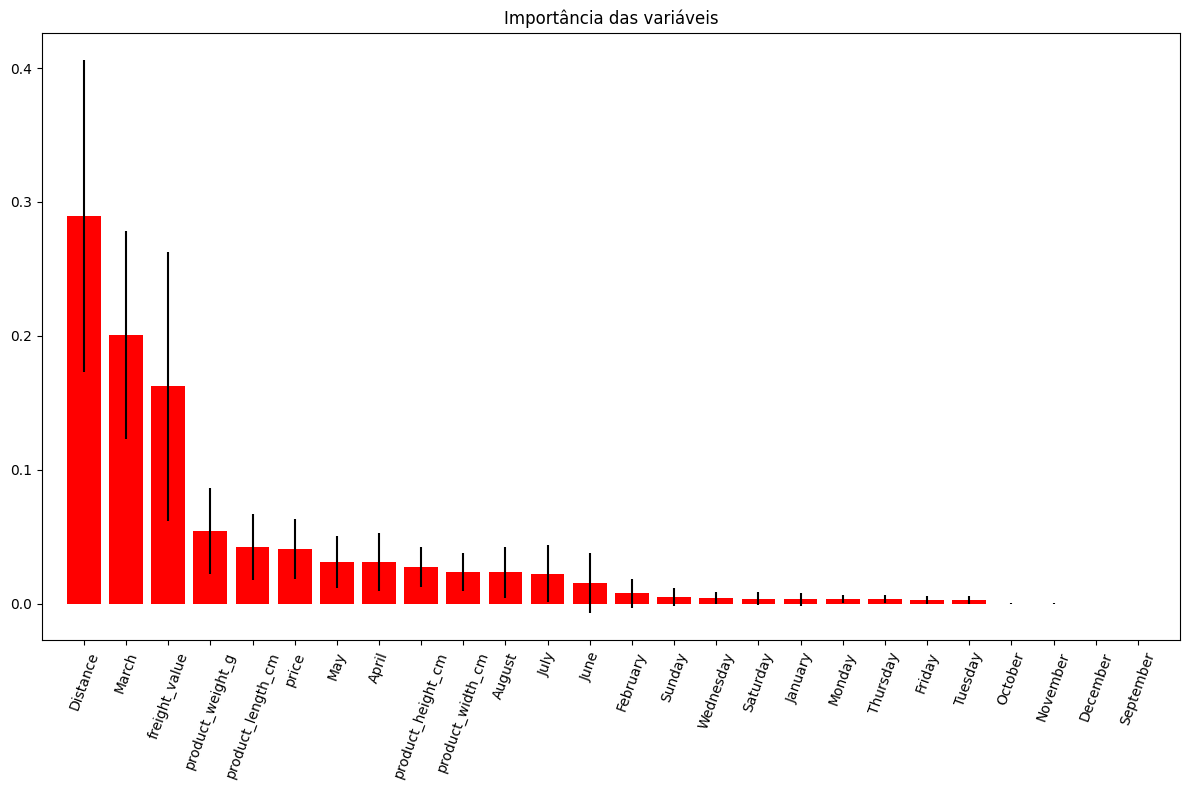

In [8]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,8))
plt.title("Importância das variáveis")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=70)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()